# Aperiodic electrophysiological activity tracks spiking statistics between behavioral states
Sawyer Figueroa, Michael Preston, Bradley Voytek

# SfN 2023, Poster Panel 
This notebook reproduces the figures from poster panel 5. Panel 5 investigates the relationship between spike-synchrony and aperiodic LFP activity. Spiking and spectral parameters are quantified with high temporal resolution in order to elucidate dynamic changes on the timescale of miliseconds. 

#

Dataset: Allen Institute for Brain Science: Visual Coding - Neuropixels  
© 2015 Allen Institute for Brain Science. Allen Brain Atlas API. Available from: https://portal.brain-map.org/explore/circuits/visual-coding-neuropixels

## Set-up

### set paths

In [1]:
# set paths
PROJECT_PATH = "G:/Shared drives/visual_encoding" # shared results directory
MANIFEST_PATH = 'D:/datasets/allen_vc' # path to manifest file and local dataset

### imports

In [2]:
%load_ext autoreload
%autoreload 2

In [39]:
# Imports
import pandas as pd
import numpy as np
import neo
import quantities as pq
from elephant.statistics import instantaneous_rate
from elephant import kernels
import matplotlib.pyplot as plt
from matplotlib import rcParams
import sys
import os
import contextlib
from time import time as timer

In [80]:
# custom imports
import sys
sys.path.append('../../')

from allen_vc.plots import plot_linregress, plot_time_resolved_params
from allen_vc.utils import print_time_elapsed
from allen_vc.analysis import compute_pyspike_metrics
from allen_vc.stats import mixedLM

print("Packages Imported")

Packages Imported


### settings

In [5]:
# matplotlib and figure appearance settings
plt.style.use(f'../../stylelib/sfn_2023.mplstyle')
# COLORS = ["#7570b3", "#3FAA96", "#F39943"]

### load data

In [7]:
# concatenate param data
dfs = []
for file in os.listdir(f'{PROJECT_PATH}/data/lfp_data/params/tfr/natural_movie_one_more_repeats/knee/by_session'):
    dfs.append(pd.read_csv(f'{PROJECT_PATH}/data/lfp_data/params/tfr/natural_movie_one_more_repeats/knee/by_session/{file}'))

all_chans = pd.concat(dfs)

FYI: The above results can typically be imported directly '<project_path>/lfp_data/params/tfr/<stim_code>/lfp_params.csv'

## Main

### ~

In [8]:
# median across channels
params = all_chans.groupby(['session', 'epoch_idx', 'window_idx']).median().drop(['chan_idx'], axis=1).reset_index()
params.head()

,session,epoch_idx,window_idx,offset,knee,exponent,cf_0,pw_0,bw_0,cf_1,pw_1,bw_1,cf_2,pw_2,bw_2,cf_3,pw_3,bw_3,error,r_squared
0,766640955,1,0,-4.115208,9.968530,2.423561,64.467576,1.233282,9.732393,94.041406,1.385570,3.384751,118.799761,1.332603,5.113630,132.435563,1.289509,10.118157,0.330113,0.885538
1,766640955,1,1,-3.954905,11.661401,2.582745,63.642010,1.232250,7.163074,99.365796,1.274334,3.202332,118.969208,1.249717,5.786398,131.225242,1.119601,11.121559,0.320669,0.891436
2,766640955,1,2,-3.810811,7.437185,2.646690,61.905297,1.044139,19.982444,114.950307,1.235087,7.364720,122.320409,1.268337,7.544635,132.205563,1.122866,10.364844,0.302633,0.903953
3,766640955,1,3,-3.675141,9.884550,2.679084,61.592062,1.109199,5.776820,73.793539,1.214822,8.454238,118.174816,1.244945,12.379198,132.435563,1.193891,11.217565,0.304857,0.901293
4,766640955,1,4,-3.742768,9.195486,2.637796,49.367178,1.149908,5.723401,74.629031,1.201398,7.115478,118.733133,1.198596,6.158769,131.744733,1.130073,12.123564,0.318002,0.898060


In [44]:
# use sliding window with same window size used for param calculation
window_size = 0.02*pq.s
region = 'VISp'

# init - add results to params dataframe
params['inst_spike_rate'] = np.nan
params['avg_pupil_area'] = np.nan
params['spike_distance'] = np.nan

# time it
start = timer()

# loop over sessions
for i_ses, ses_id in enumerate(params['session'].unique()):
    print(f"Computing session: {ses_id} ({i_ses+1}/{len(params['session'].unique())})")

    # load session data
    block = neo.io.NeoMatlabIO(f'{PROJECT_PATH}/data/blocks/segmented/natural_movie_one_more_repeats/block_{ses_id}.mat').read_block()
    seg = block.segments[0]
    spiketrains = seg.filter({'brain_structure': region}, objects=neo.SpikeTrain) # get only region units
    
    # init
    seg_pupil_area = []
    spk_dist = []
    i = seg.annotations['stimulus_onset']*pq.s
    
    # loop over sliding window
    while i <= seg.t_stop - window_size:
        
        # calculate average pupil area over window
        if len(seg.analogsignals) > 1:
            seg_pupil_area.append(np.mean(seg.analogsignals[1].time_slice(i, i+window_size)))
        else:
            seg_pupil_area.append(np.nan)
            
        # calculate spike distance over interval
        with contextlib.redirect_stdout(None): # suppress spk.spike_distance output
            if len(spiketrains) > 1:
                spk_dist.append(compute_pyspike_metrics(spiketrains, (i.item(), (i+window_size).item()))[0])
            else:
                spk_dist.append(np.nan)
        
        # increment window
        i += window_size
        
    if len(spiketrains) > 1:
        seg_rates = instantaneous_rate(spiketrains, sampling_period=0.02*pq.s, kernel=kernels.GaussianKernel(sigma=0.01*pq.s)).magnitude.mean(axis=1)
    else:
        seg_rates = [np.nan]*len(spk_dist)

    # add segment data to params dataframe
    params.loc[params['session']==ses_id, 'inst_spike_rate'] = seg_rates
    params.loc[params['session']==ses_id, 'spike_distance'] = spk_dist
    params.loc[params['session']==ses_id, 'avg_pupil_area'] = seg_pupil_area

# save/show results
params.to_csv(f'{PROJECT_PATH}/data/lfp_data/params/tfr/natural_movie_one_more_repeats/knee/params_{region}.csv', index=False)
print_time_elapsed(start)
params.head()

Computing session: 766640955 (1/23)
Computing session: 767871931 (2/23)
Computing session: 768515987 (3/23)
Computing session: 771160300 (4/23)
Computing session: 771990200 (5/23)
Computing session: 774875821 (6/23)
Computing session: 778240327 (7/23)
Computing session: 778998620 (8/23)
Computing session: 779839471 (9/23)
Computing session: 781842082 (10/23)
Computing session: 786091066 (11/23)
Computing session: 787025148 (12/23)
Computing session: 789848216 (13/23)
Computing session: 793224716 (14/23)
Computing session: 794812542 (15/23)
Computing session: 816200189 (16/23)
Computing session: 821695405 (17/23)
Computing session: 829720705 (18/23)
Computing session: 831882777 (19/23)
Computing session: 835479236 (20/23)
Computing session: 839068429 (21/23)
Computing session: 840012044 (22/23)
Computing session: 847657808 (23/23)
2 hours, 51 minutes, and 42.4 seconds


,session,epoch_idx,window_idx,offset,knee,exponent,cf_0,pw_0,bw_0,cf_1,...,pw_2,bw_2,cf_3,pw_3,bw_3,error,r_squared,inst_spike_rate,avg_pupil_area,spike_distance
0,766640955,1,0,-4.115208,9.968530,2.423561,64.467576,1.233282,9.732393,94.041406,...,1.332603,5.113630,132.435563,1.289509,10.118157,0.330113,0.885538,3.479088,0.002671,0.211924
1,766640955,1,1,-3.954905,11.661401,2.582745,63.642010,1.232250,7.163074,99.365796,...,1.249717,5.786398,131.225242,1.119601,11.121559,0.320669,0.891436,7.116836,0.002669,0.216571
2,766640955,1,2,-3.810811,7.437185,2.646690,61.905297,1.044139,19.982444,114.950307,...,1.268337,7.544635,132.205563,1.122866,10.364844,0.302633,0.903953,10.586037,0.002682,0.220487
3,766640955,1,3,-3.675141,9.884550,2.679084,61.592062,1.109199,5.776820,73.793539,...,1.244945,12.379198,132.435563,1.193891,11.217565,0.304857,0.901293,11.181677,0.002681,0.233542
4,766640955,1,4,-3.742768,9.195486,2.637796,49.367178,1.149908,5.723401,74.629031,...,1.198596,6.158769,131.744733,1.130073,12.123564,0.318002,0.898060,14.245542,0.002670,0.242386


In [53]:
# load/concat results from cell above
vis_in = f'{PROJECT_PATH}/data/lfp_data/params/tfr/natural_movie_one_more_repeats/knee/params_VISp.csv'
lgd_in = f'{PROJECT_PATH}/data/lfp_data/params/tfr/natural_movie_one_more_repeats/knee/params_LGd.csv'
params = pd.concat([pd.read_csv(vis_in).assign(brain_structure='VISp'), pd.read_csv(lgd_in).assign(brain_structure='LGd')]).dropna(axis=0,subset=['avg_pupil_area', 'inst_spike_rate']) # drop null values for pupil area and spike rate
params['session'] = params['session'].astype(str)
params.head()

,session,epoch_idx,window_idx,offset,knee,exponent,cf_0,pw_0,bw_0,cf_1,...,bw_2,cf_3,pw_3,bw_3,error,r_squared,inst_spike_rate,avg_pupil_area,spike_distance,brain_structure
0,766640955,1,0,-4.115208,9.968530,2.423561,64.467576,1.233282,9.732393,94.041406,...,5.113630,132.435563,1.289509,10.118157,0.330113,0.885538,3.479088,0.002671,0.211924,VISp
1,766640955,1,1,-3.954905,11.661401,2.582745,63.642010,1.232250,7.163074,99.365796,...,5.786398,131.225242,1.119601,11.121559,0.320669,0.891436,7.116836,0.002669,0.216571,VISp
2,766640955,1,2,-3.810811,7.437185,2.646690,61.905297,1.044139,19.982444,114.950307,...,7.544635,132.205563,1.122866,10.364844,0.302633,0.903953,10.586037,0.002682,0.220487,VISp
3,766640955,1,3,-3.675141,9.884550,2.679084,61.592062,1.109199,5.776820,73.793539,...,12.379198,132.435563,1.193891,11.217565,0.304857,0.901293,11.181677,0.002681,0.233542,VISp
4,766640955,1,4,-3.742768,9.195486,2.637796,49.367178,1.149908,5.723401,74.629031,...,6.158769,131.744733,1.130073,12.123564,0.318002,0.898060,14.245542,0.002670,0.242386,VISp


In [79]:
help(plot_linregress)

Help on function plot_linregress in module allen_vc.plots:

plot_linregress(df, x_data, y_data, group=None, multireg=False, title=None, legend=False, fname_out=None, show=False)
    Calculate and plot the linear regression of two columns in a dataframe.
    
    Parameters
    ----------
    x_data : str
        column with x-values of dataset
    y_data : str
        column with y-values of dataset
    group: str, optional
        column to color/section data by
    multireg: bool, optional
        whether or not to plot regression lines for each group
    title : str, optional
        Title of the plot
    fname_out : str, optional
        Filename of the output figure
    show : bool, optional
        Whether to show the figure or not
    
    Returns
    -------
    None



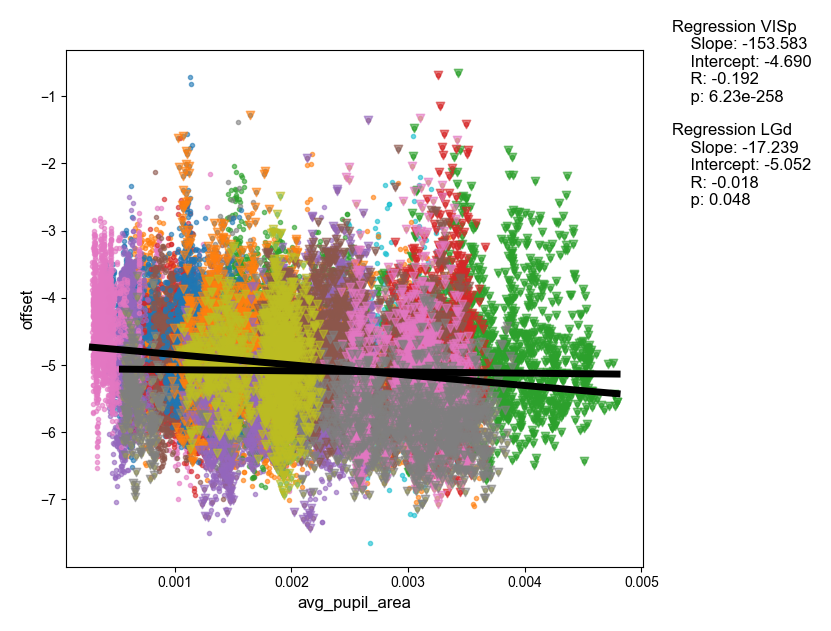

In [77]:
plot_linregress(params, 'avg_pupil_area', 'offset', group='session', show=True)

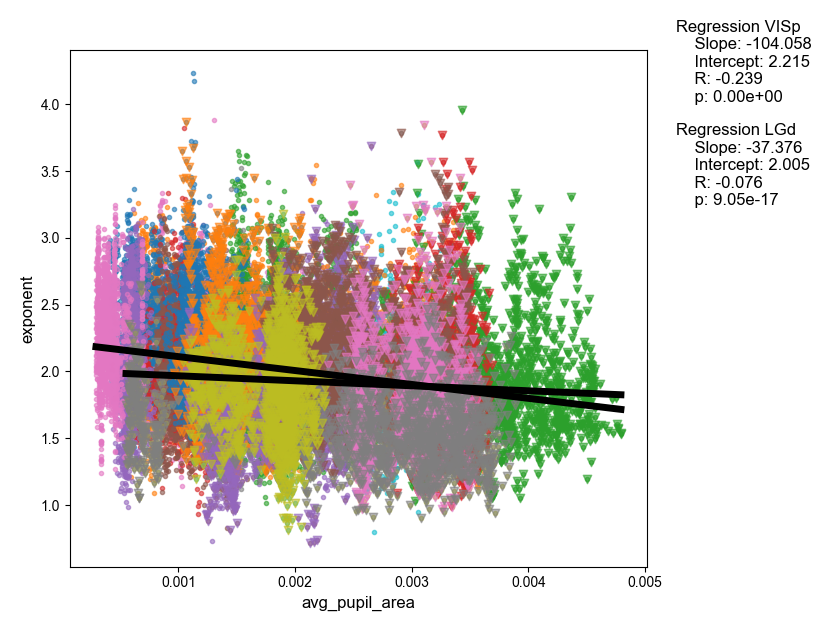

In [63]:
plot_linregress(params, 'avg_pupil_area', 'exponent', group='session', show=True)

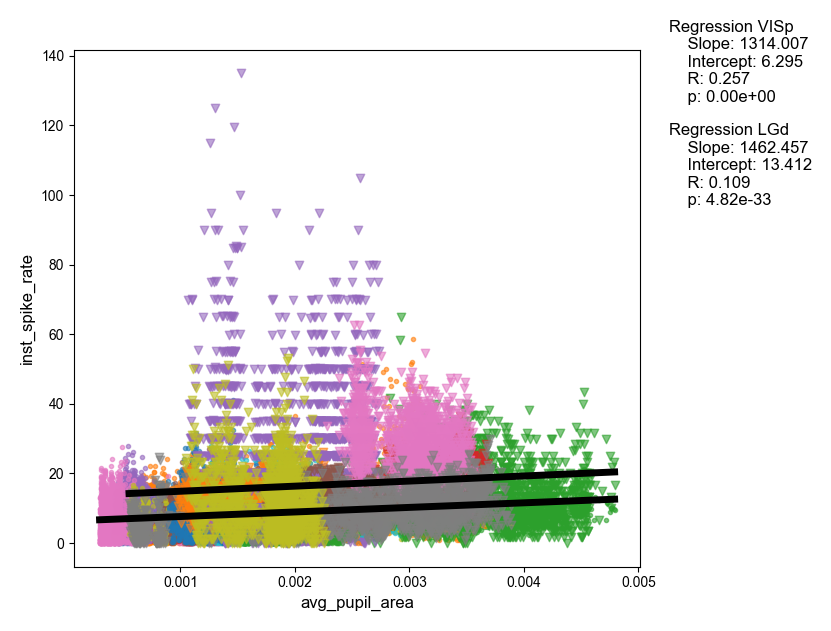

In [64]:
plot_linregress(params, 'avg_pupil_area', 'inst_spike_rate', group='session', show=True)

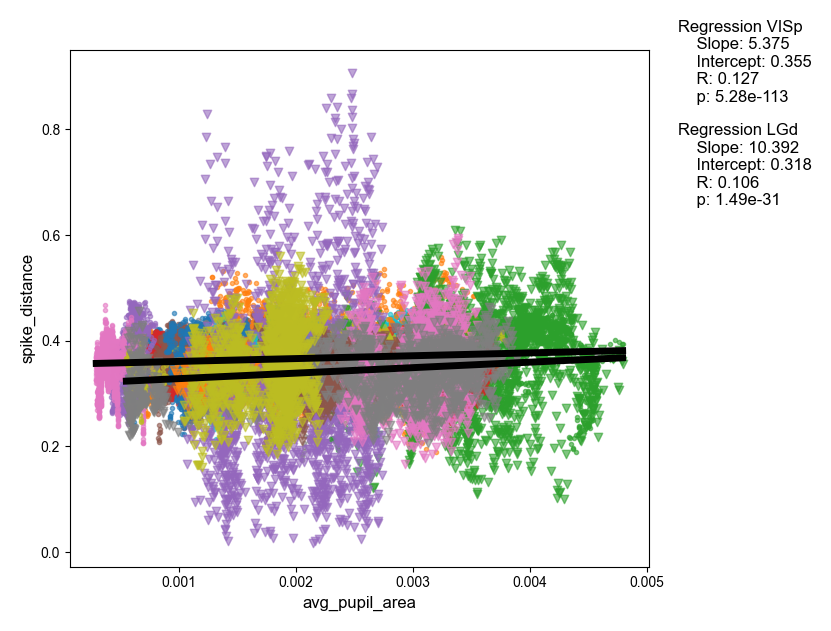

In [65]:
plot_linregress(params, 'avg_pupil_area', 'spike_distance', group='session', show=True)

### Parameter time series

In [75]:
help(plot_time_resolved_params)

Help on function plot_time_resolved_params in module allen_vc.plots:

plot_time_resolved_params(df, session, window, fs, title=None)
    Plot normalized time resolved aperiodic parameters.
    
    Parameters
    ----------
    df : pd.DataFrame
        dataframe containing lfp parameter data.
    session: str
        session from which to draw data.
    window: tuple of ints
        window indices corresponding to the window of data to plot.
    fs: int
        sampling frequency of data.
    title : str, optional
        title of the produced plot
    
    Returns
    -------
    None



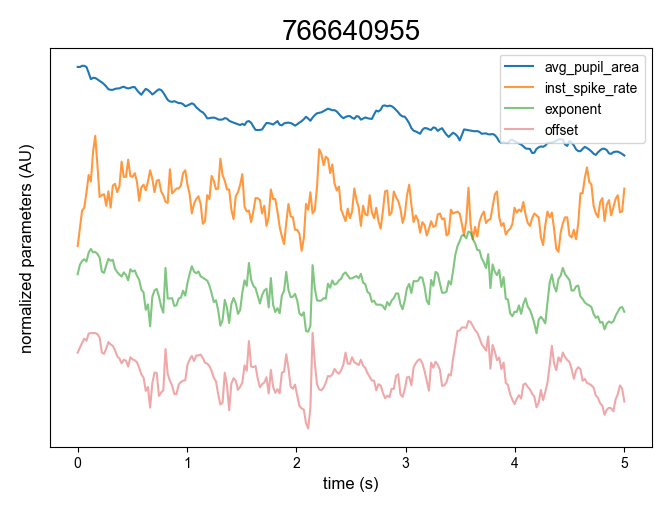

In [74]:
plot_time_resolved_params(params[params['brain_structure']=='VISp'], '766640955', (0,250), 50)

### Statistics

In [ ]:
# linear mixed effect model

In [84]:
# instantaneous spike rate

for region in params['brain_structure'].unique():
    print(region + '\n\n\n')
    region_df = params[params['brain_structure']==region]
    
    mixedLM(region_df, 'inst_spike_rate', ['window_idx'], 'session')

VISp



          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: y          
No. Observations: 31500   Method:             REML       
No. Groups:       21      Scale:              18.2590    
Min. group size:  1500    Log-Likelihood:     -90547.6357
Max. group size:  1500    Converged:          Yes        
Mean group size:  1500.0                                 
---------------------------------------------------------
              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------
x1            -0.001    0.000 -21.715 0.000 -0.001 -0.001
Group Var     96.927    6.901                            

LGd



          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: y          
No. Observations: 12000   Method:             REML       
No. Groups:       8       Scale:              76.1628    
Min. group size:  1500    Log-Likelihood:     -43067.1929
Max. group size:  

In [82]:
# offset

for region in params['brain_structure'].unique():
    print(region + '\n\n\n')
    region_df = params[params['brain_structure']==region]
    
    mixedLM(region_df, 'offset', ['window_idx'], 'session')

VISp



          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: y          
No. Observations: 31500   Method:             REML       
No. Groups:       21      Scale:              0.5183     
Min. group size:  1500    Log-Likelihood:     -34471.2440
Max. group size:  1500    Converged:          Yes        
Mean group size:  1500.0                                 
----------------------------------------------------------
            Coef.   Std.Err.    z    P>|z|  [0.025  0.975]
----------------------------------------------------------
x1           0.000     0.000  5.733  0.000   0.000   0.000
Group Var   23.526     9.445                              

LGd



          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: y          
No. Observations: 12000   Method:             REML       
No. Groups:       8       Scale:              0.5416     
Min. group size:  1500    Log-Likelihood:     -13402.1715
Max. group si

In [83]:
# exponent

for region in params['brain_structure'].unique():
    print(region + '\n\n\n')
    region_df = params[params['brain_structure']==region]
    
    mixedLM(region_df, 'exponent', ['window_idx'], 'session')

VISp



          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: y          
No. Observations: 31500   Method:             REML       
No. Groups:       21      Scale:              0.1435     
Min. group size:  1500    Log-Likelihood:     -14243.6618
Max. group size:  1500    Converged:          Yes        
Mean group size:  1500.0                                 
----------------------------------------------------------
             Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
----------------------------------------------------------
x1           0.000     0.000  6.250  0.000   0.000   0.000
Group Var    3.983     3.191                              

LGd



         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: y         
No. Observations: 12000   Method:             REML      
No. Groups:       8       Scale:              0.1392    
Min. group size:  1500    Log-Likelihood:     -5247.5358
Max. group size:  